# **introduction**

In this notebook we have data and analyzes of people who checked whether they had diabetes or not, based on several data such as body mass, age, whether the test owner was a pregnant woman, and blood glucose and insulin levels.
Based on this data, I want to build a model capable of distinguishing between diabetics.

## First of all, let's start by downloading the important libraries we need

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

## Because the column names do not explain what the values inside them represent, I did a search to verify the names of the columns and changed them accordingly.

In [ ]:
df = pd.read_csv('Dataset.csv' , sep=';')
df.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


##Well, now we will display information about the data and some other information related to it

Here we will see the Unique values in our main class

In [ ]:
df['Outcome'].unique()

array(['tested_positive', 'tested_negative'], dtype=object)

Here we will change the values of the main class from positive and negative to one and zero to facilitate the process of dealing with them.

In [ ]:
df['Outcome'] = df['Outcome'].replace({'tested_negative': 0, 'tested_positive': 1})

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


# **Visualization and cleaning**

## Here we will replace the values that are zero with Nan, and then we display the information for the columns that contain Nan and see if it is logical or not, and if it is not logical we will replace it with the  mean for each column

In [ ]:
df_copy = df.copy(deep = True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

## showing the count of Nans
print(df_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Here we will make an exception for the columns Pregnancies, age and outcome because the columns Pregnancies and outcome from logic that they contain values equal to zero

### Aiming to impute nan values for the columns in accordance with their distribution


In [ ]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace = True)

## Here we will show some comparisons between the original and the modified data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f416f0e8240>,
      dtype=object)

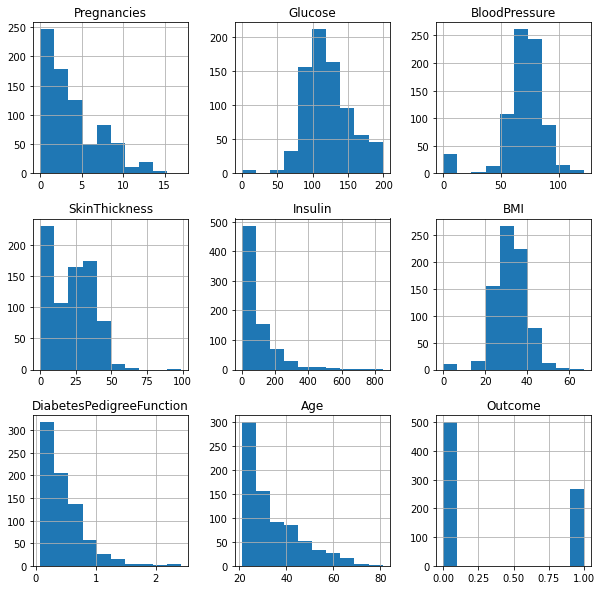

In [ ]:
df.hist(figsize = (10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4160c678d0>,
      dtype=object)

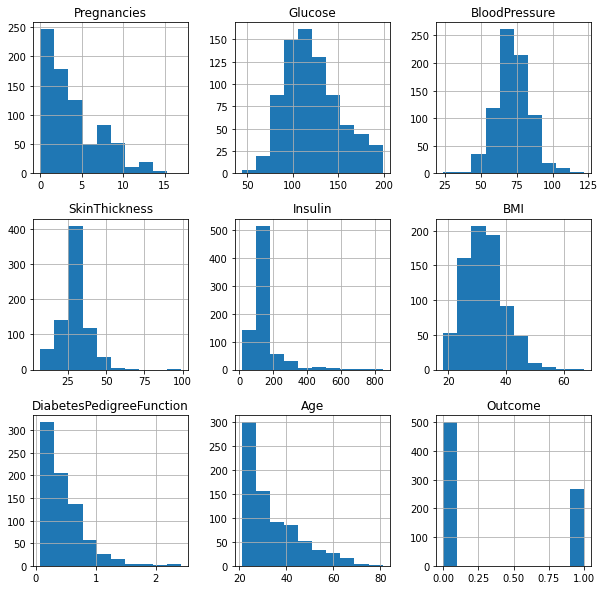

In [ ]:
df_copy.hist(figsize = (10,10))

In [ ]:
df.shape

(768, 9)

## null count analysis

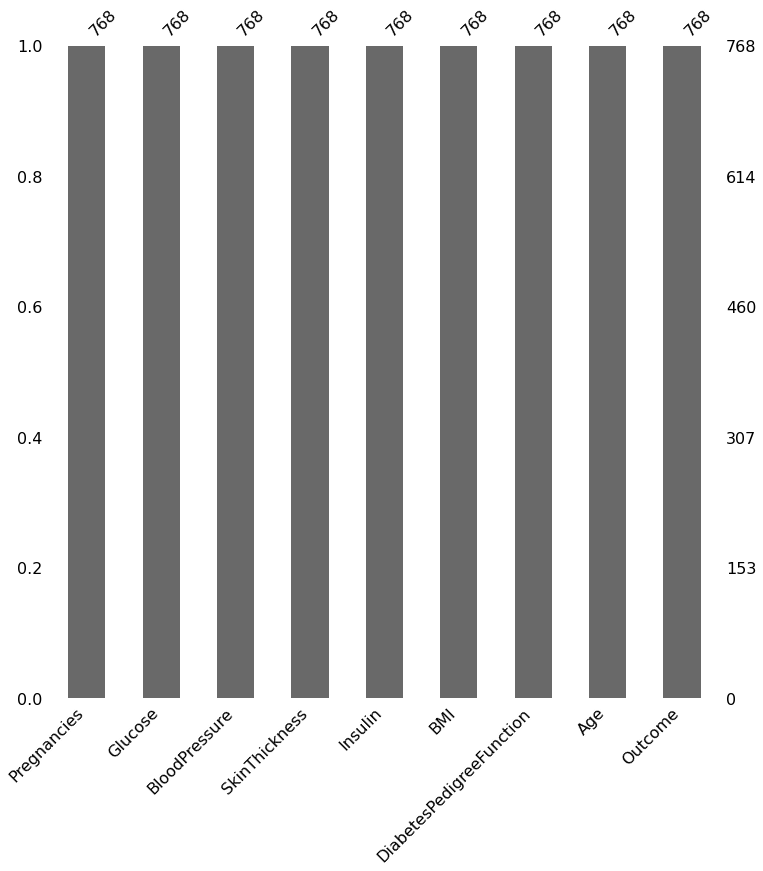

In [ ]:
import missingno as msno
p=msno.bar(df , figsize=(12,12))

## checking the balance of the data by plotting the count of outcomes by their value


0    500
1    268
Name: Outcome, dtype: int64


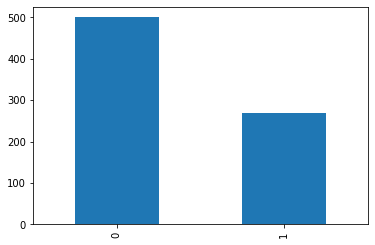

In [ ]:
print(df.Outcome.value_counts())
p=df.Outcome.value_counts().plot(kind="bar")

The above graph shows that the data is biased towards datapoints having outcome value as 0 where it means that diabetes was not present actually. The number of non-diabetics is almost twice the number of diabetic patients

## Scatter matrix of uncleaned data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f416109d0b8>,
      dtype=object)

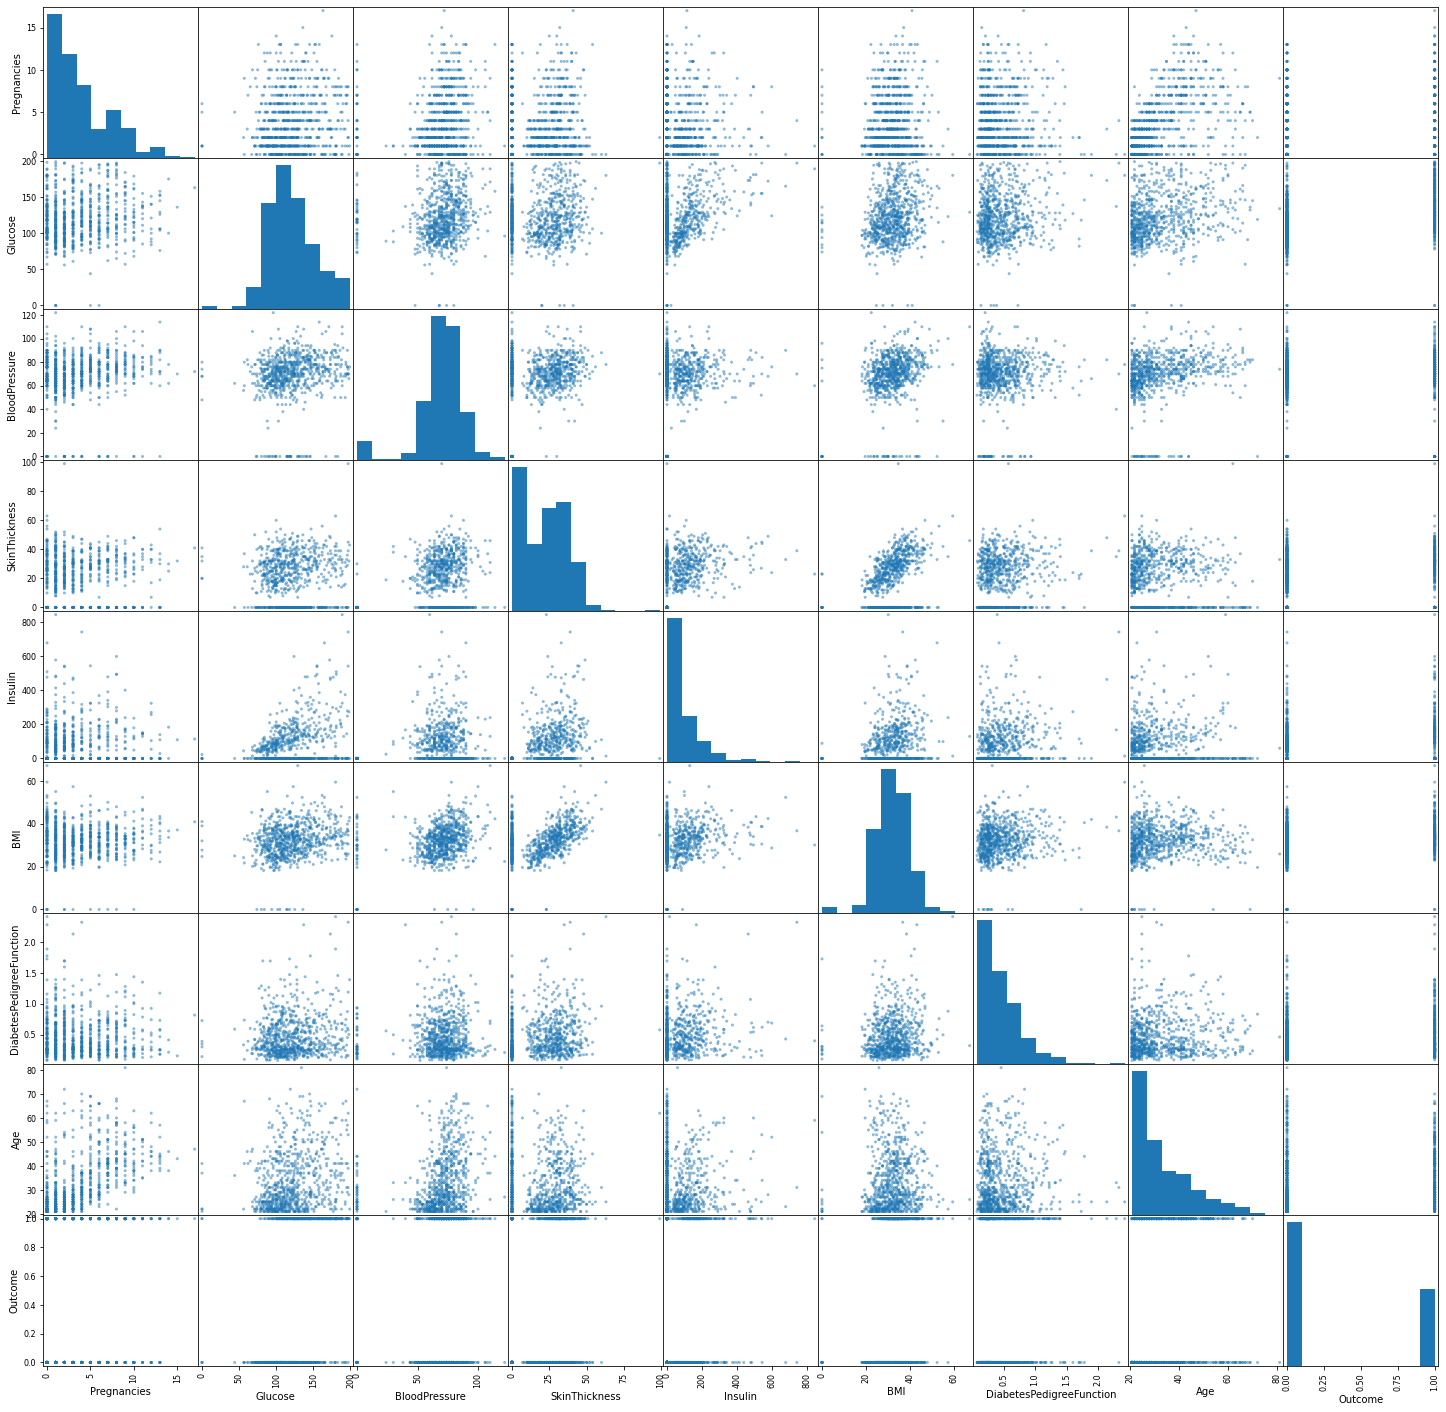

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df,figsize=(25, 25))

## Pair plot comparisons between the original and the modified data

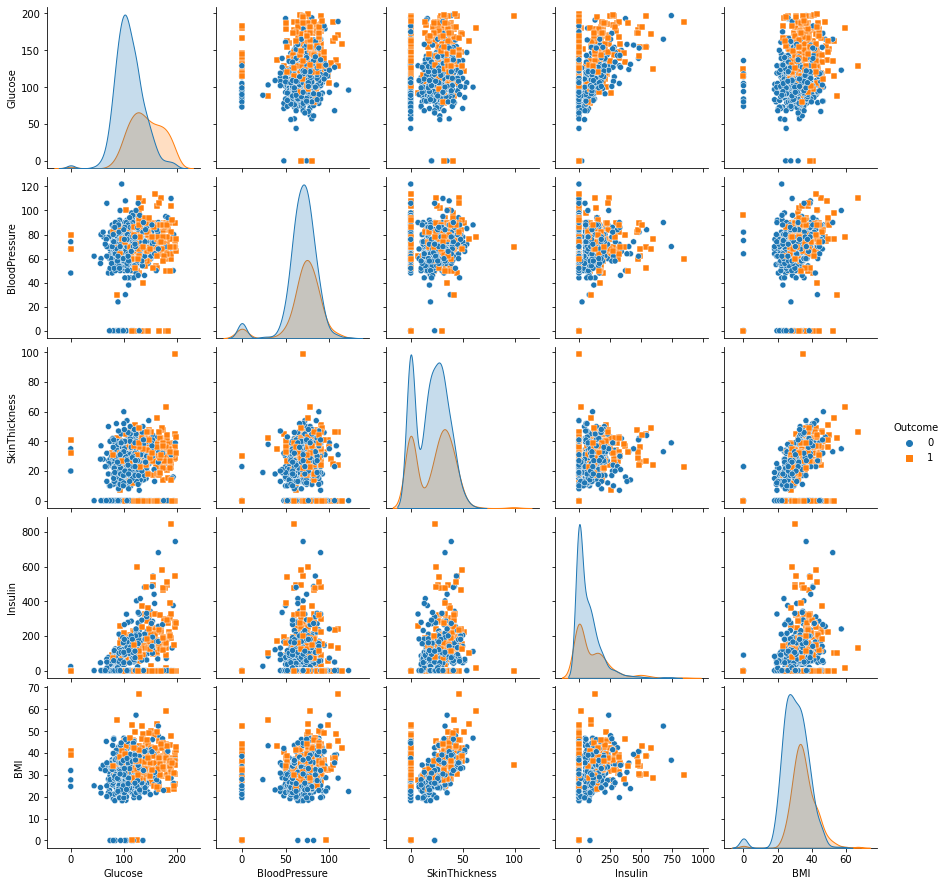

In [ ]:
sns.pairplot(df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','Outcome']] , hue='Outcome' , markers=["o", "s"])

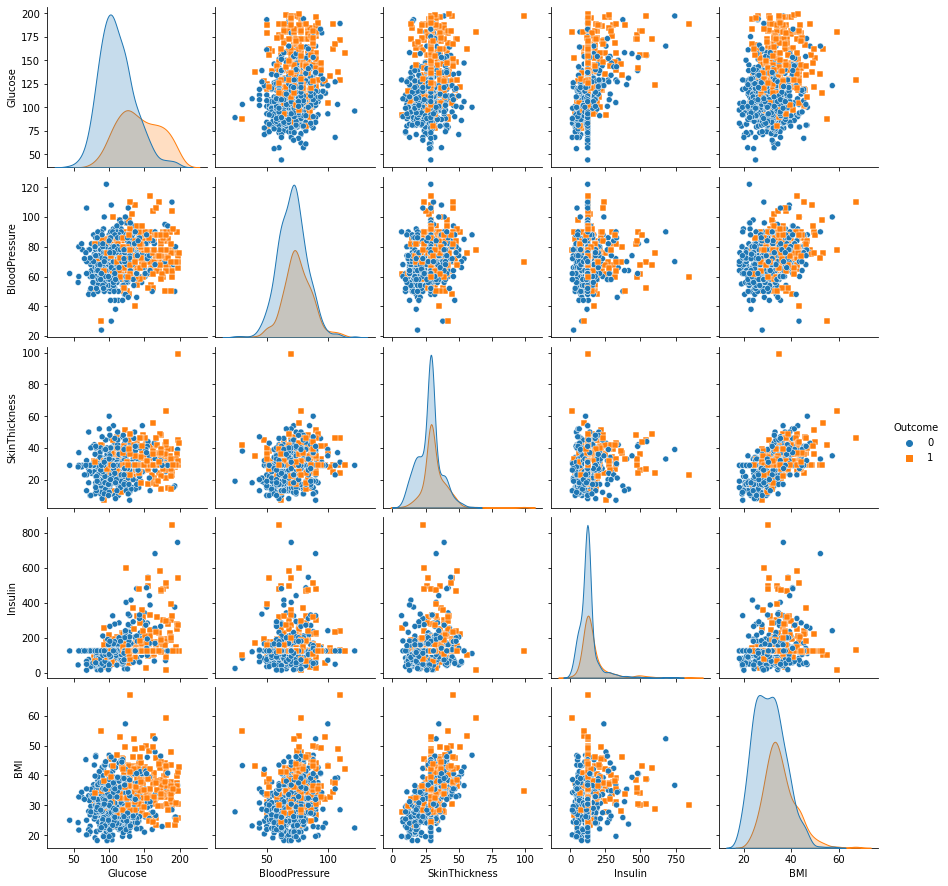

In [ ]:
sns.pairplot(df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','Outcome']] , markers=["o", "s"] ,hue = 'Outcome')

## Heatmap between the original and the modified data

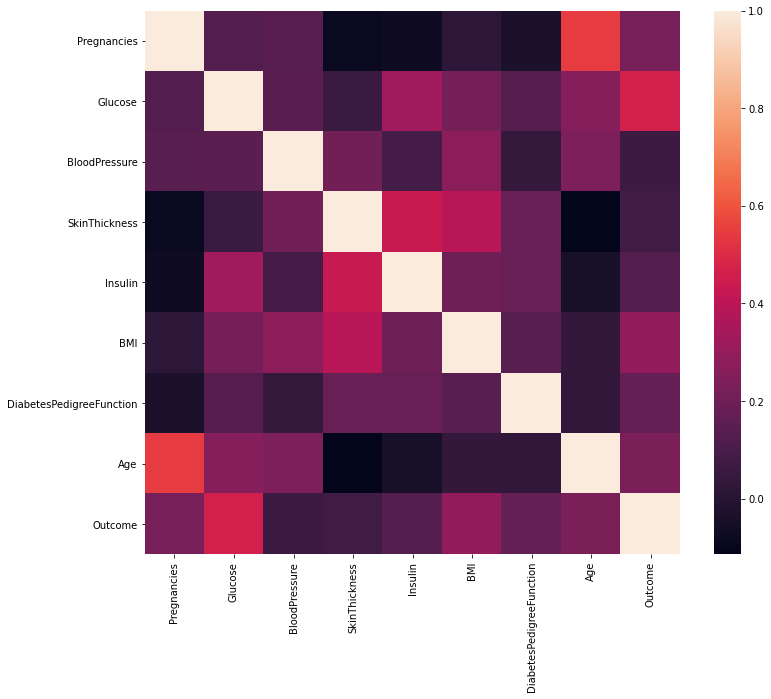

In [ ]:
plt.figure(figsize=(12,10))  
p=sns.heatmap(df.corr())

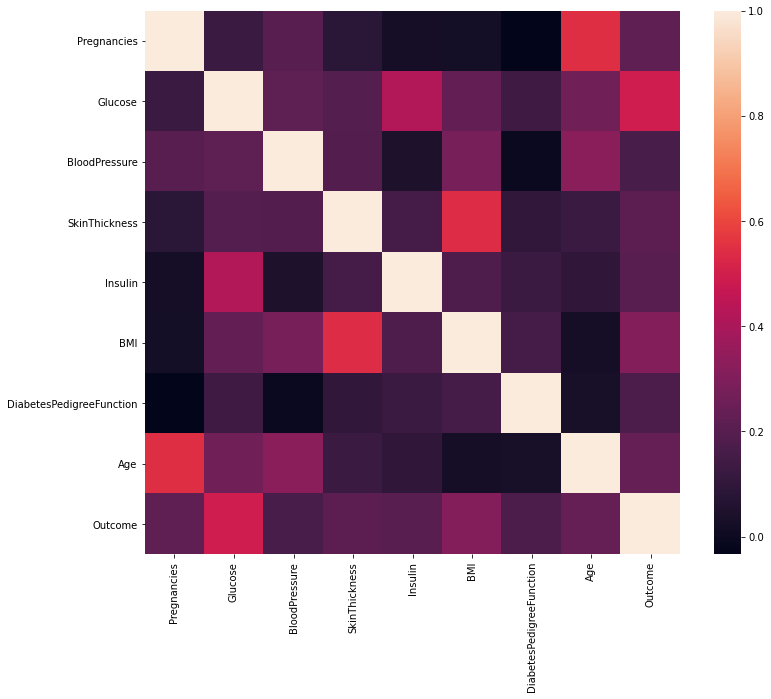

In [ ]:
plt.figure(figsize=(12,10))  
p=sns.heatmap(df_copy.corr())

### **Scaling the data**
data Z is rescaled such that μ = 0 and 𝛔 = 1

In [ ]:
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(df_copy.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [ ]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


In [ ]:
y = df_copy.Outcome

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42, stratify=y)

it is always advisable to bring all the features to the same scale for applying distance based algorithms like KNN.

We can imagine how the feature with greater range with overshadow or dimenish the smaller feature completely and this will impact the performance of all distance based model as it will give higher weightage to variables which have higher magnitude.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

### score that comes from testing on the same datapoints that were used for training

In [ ]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


### score that comes from testing on the datapoints that were split in the beginning to be used for testing solely

In [ ]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 76.77165354330708 % and k = [11]


### Result Visualisation

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


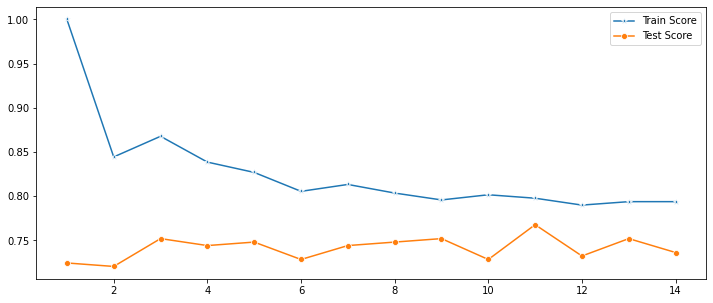

In [ ]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

### The best result is captured at k = 11 hence 11 is used for the final model

In [ ]:
knn = KNeighborsClassifier(11)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7677165354330708

### trying to plot decision boundary

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:242: UserWarning: No contour levels were found within the data range.
  antialiased=True)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


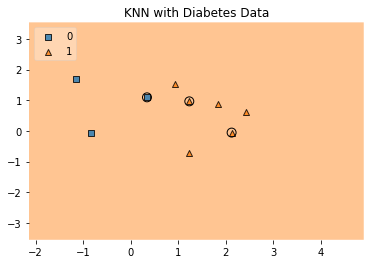

In [ ]:
value = 20000
width = 20000
plot_decision_regions(X.values, y.values, clf=knn, legend=2, 
                      filler_feature_values={2: value, 3: value, 4: value, 5: value, 6: value, 7: value},
                      filler_feature_ranges={2: width, 3: width, 4: width, 5: width, 6: width, 7: width},
                      X_highlight=X_test.values)

# Adding axes annotations
#plt.xlabel('sepal length [cm]')
#plt.ylabel('petal length [cm]')
plt.title('KNN with Diabetes Data')
plt.show()

#let us get the predictions using the classifier we had fit above

In [ ]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,141,24,165
1,35,54,89
All,176,78,254


Text(0.5, 15.0, 'Predicted label')

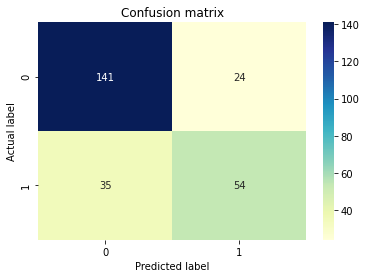

In [ ]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Classification Report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       165
           1       0.69      0.61      0.65        89

    accuracy                           0.77       254
   macro avg       0.75      0.73      0.74       254
weighted avg       0.76      0.77      0.76       254



# ROC - AUC

ROC (Receiver Operating Characteristic) Curve tells us about how good the model can distinguish between two things (e.g If a patient has a disease or no). Better models can accurately distinguish between the two. Whereas, a poor model will have difficulties in distinguishing between the two

In [ ]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

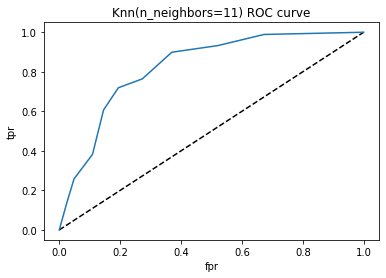

In [ ]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

##Area under ROC curve

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8247191011235955

##In case of classifier like knn the parameter to be tuned is n_neighbors

In [ ]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7721840251252015
Best Parameters: {'n_neighbors': 25}


In [ ]:
df_copy.to_csv('diabetes.csv')